In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt


In [3]:
def load_batch_npy(source_folder, batch_index):
    image_path = os.path.join(source_folder, f'images_batch_{batch_index}.npy')
    label_path = os.path.join(source_folder, f'labels_batch_{batch_index}.npy')
    images = np.load(image_path)
    labels = np.load(label_path)
    return images, labels

def extract_features_batch(images, model, target_size=(224, 224)):
    features = []
    for image in images:
        # If image is grayscale (single channel), convert it to 3-channel.
        if len(image.shape) == 2:
            image = np.stack([image]*3, axis=-1)
        # Resize image if needed.
        image_resized = tf.image.resize(image, target_size).numpy()
        # Preprocess the image for ResNet50.
        image_preprocessed = preprocess_input(image_resized.astype(np.float32))
        # Expand dims so the image becomes (1, height, width, channels)
        image_expanded = np.expand_dims(image_preprocessed, axis=0)
        # Extract features using the pretrained model.
        feature = model.predict(image_expanded)
        # Flatten the feature vector.
        features.append(feature.flatten())
    return np.array(features)

In [4]:
def process_all_batches(source_folder, num_batches, model):
    all_features = []
    all_labels = []
    for i in range(num_batches):
        print(f"Processing batch {i}")
        images, labels = load_batch_npy(source_folder, i)
        features = extract_features_batch(images, model)
        all_features.append(features)
        all_labels.append(labels)
    # Concatenate all batches into single arrays.
    all_features = np.concatenate(all_features, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    return all_features, all_labels

In [5]:
# Set the folder where your preprocessed .npy files are stored.
source_folder = '/Users/issackondreddy/Desktop/Programming/ML Project/Lung Cancer Detection/data/processed'

# Set the total number of batches (adjust as needed; for example, 181 batches means indices 0 to 180).
num_batches = 181

# Load the pretrained ResNet50 model without the top layer and with global average pooling.
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
model = Model(inputs=base_model.input, outputs=base_model.output)

# Extract features from all batches.
features, labels = process_all_batches(source_folder, num_batches, model)
print("Feature extraction complete. Features shape:", features.shape)


Processing batch 0
1/1 [==============================] - 0s 45ms/step
Processing batch 1
1/1 [==============================] - 0s 47ms/step
Processing batch 2
1/1 [==============================] - 0s 46ms/step
Processing batch 3
1/1 [==============================] - 0s 46ms/step
Processing batch 4
1/1 [==============================] - 0s 45ms/step
Processing batch 5
1/1 [==============================] - 0s 46ms/step
Processing batch 6
1/1 [==============================] - 0s 53ms/step
Processing batch 7
1/1 [==============================] - 0s 47ms/step
Processing batch 8
1/1 [==============================] - 0s 47ms/step
Processing batch 9
1/1 [==============================] - 0s 47ms/step
Processing batch 10
1/1 [==============================] - 0s 45ms/step
Processing batch 11
1/1 [==============================] - 0s 45ms/step
Processing batch 12
1/1 [==============================] - 0s 46ms/step
Processing batch 13
1/1 [==============================] - 0s 45ms/step
Pr

In [6]:
# Feature selection using SelectKBest with ANOVA F-test.
# Here, we select the top 100 features. Adjust k as needed.
selector = SelectKBest(score_func=f_classif, k=100)
selected_features = selector.fit_transform(features, labels)
print("Feature selection complete. Selected features shape:", selected_features.shape)


Feature selection complete. Selected features shape: (2888, 100)


Saved selected features and labels to /Users/issackondreddy/Desktop/Programming/ML Project/Lung Cancer Detection/data/features_selected_resnet50


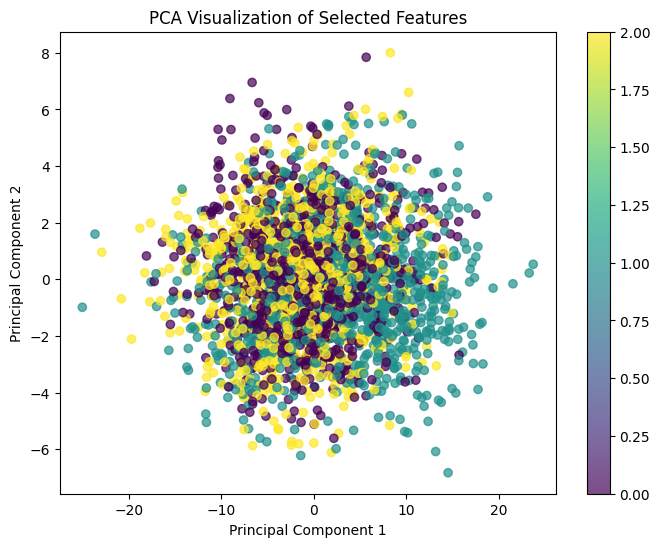

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Let's assume 'selected_features' is your feature array from feature selection.
pca = PCA(n_components=2)
features_2d = pca.fit_transform(selected_features)

plt.figure(figsize=(8, 6))
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Selected Features')
plt.colorbar()
plt.show()
